In [1]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# X, y = load_digits().data, load_digits().target
# X = X/255.

# L = len(X)
# X_train, y_train, X_test, y_test = X[L//3 : L], y[L//3 : L], X[0 : L//3], y[0 : L//3]

In [3]:
import zipfile

# Unzipping the dataset
zipf = zipfile.ZipFile("digit-recognizer.zip")
zipf.extractall()
zipf.close()

In [4]:
df = pd.read_csv("train.csv")
df.head(3)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df.shape

(42000, 785)

In [6]:
# Converting the data frame to numpy array
# Data is a matrix with 42000 rows (sample digits),
# and 785 columns(28 X 28 pixels + 1 label column).
data = np.array(df)

m, n = data.shape

np.random.shuffle(data)

In [7]:
# Earlier first column was the label column, and the other columns were pixels from 0 to 783.
# That is every row starting from column 1, was an image.
# Transposing the array will give us every column as a sample image with first row being the labels for every image column.
train_data, test_data = data[0:int(m-m/8)], data[int(m-m/8):m]
X_train, y_train, X_test, y_test = train_data[:, 1:], train_data[:, 0], test_data[:, 1:], test_data[:, 0]
X_train, X_test = X_train/255., X_test/255.

In [8]:
def one_hot(Y):
  one_hot_Y = np.zeros((Y.size, Y.max()+1))
  one_hot_Y[np.arange(Y.size), Y] = 1
  # one_hot_Y = one_hot_Y.T
  return one_hot_Y

In [9]:
# Rectified Linear Unit
def ReLU(X):
  return np.maximum(0, X)

def deriv_ReLU(X):
  return X > 0


# Sigmoid function
def sigmoid(X):
  return np.exp(X) / (1+np.exp(X))

def deriv_sigmoid(X):
  sig = sigmoid(X)
  return sig * (1 - sig)


# tanh function
def tanh(X):
  return (np.exp(2*X) - 1) / (np.exp(2*X) + 1)

def deriv_tanh(X):
  return 1 - tanh(X) ** 2


# Softmax function
def softmax(X):
  exp_X = np.exp(X - np.max(X, axis=-1, keepdims=True))
  return exp_X / np.sum(exp_X, axis=-1, keepdims=True)


In [10]:
def get_prediction(X):
  return np.argmax(X, 1)

In [11]:
def get_accuracy(predictions, Y):
  print(predictions, Y)
  return np.sum(predictions == Y)/Y.size

In [12]:
def categorical_crossentropy(y_pred, y):
  # Avoid numerical instability by adding a small constant to prevent log (0)
  epsilon = 1e-15
  y_pred = np.clip(y_pred, epsilon, 1-epsilon)

  loss = -np.sum(y * np.log(y_pred)) / len(y)

  return loss

In [28]:
class NN:
  def __init__(self, layers, input_size = 784, output=10):
    np.random.seed(0)
    model = {}
    model['W1'] = np.random.randn(input_size, layers[0])
    model['b1'] = np.zeros((1, layers[0]))

    for i in range(1, len(layers)):
      model[f'W{i+1}'] = np.random.randn(layers[i-1], layers[i])
      model[f'b{i+1}'] = np.zeros((1, layers[i]))

    model[f'W{len(layers)+1}'] = np.random.randn(layers[-1], output)
    model[f'b{(len(layers)+1)}'] = np.zeros((1, output))

    self.model = model


  def forward_prop(self, X):
    input = X
    self.history = []
    L = len(self.model) // 2

    for i in range(1, L):
      W = self.model[f'W{i}']
      b = self.model[f'b{i}']

      Z = np.dot(input, W) + b
      A = ReLU(Z)

      self.history.append([W, b, Z, A])
      input = A

    W_output = self.model[f'W{L}']
    b_output = self.model[f'b{L}']
    Z_output = np.dot(input, W_output) + b_output
    A_output = softmax(Z_output)

    self.history.append([W_output, b_output, Z_output, A_output])
    return A_output


  def backward_prop(self, X, y_hat, y):
    deltas = {}
    L = len(self.history)
    m = X.shape[0]
    Y = one_hot(y)

    # Output Layer gradients
    dZ_output = y_hat - Y
    deltas[f'dW{L}'] = 1/m * np.dot(self.history[L-2][3].T, dZ_output)
    deltas[f'db{L}'] = 1/m * np.sum(dZ_output, axis=0)

    # Hidden Layer gradients
    dZ = dZ_output
    for i in reversed(range(1, L-1)):
      W = self.history[i+1][0]
      Z = self.history[i][3]

      dZ = deriv_ReLU(Z) * np.dot(dZ, W.T)
      deltas[f'dW{i+1}'] = 1/m * np.dot(self.history[i-1][3].T, dZ)
      deltas[f'db{i+1}'] = 1/m * np.sum(dZ, axis=0)

    W, Z = self.history[1][0], self.history[0][3]
    dZ = deriv_ReLU(Z) * np.dot(dZ, W.T)
    deltas[f'dW1'] = 1/m * np.dot(X.T, dZ)
    deltas[f'db1'] = 1/m * np.sum(dZ, axis = 0)

    return deltas


  def update_parameters(self, deltas, lr):
    L = len(self.history)

    for i in range(1, L+1):
      self.model[f'W{i}'] -= lr * deltas[f'dW{i}']
      self.model[f'b{i}'] -= lr * deltas[f'db{i}']


  def gradient_descent(self, X, y, epochs, lr):
    for epoch in range(epochs):
      forward_output = self.forward_prop(X)
      deltas = self.backward_prop(X, forward_output, y)
      self.update_parameters(deltas, lr)
      loss = categorical_crossentropy(forward_output, one_hot(y))
      if epoch % 100 == 0:
        print(f'Epochs: {epoch},  Accuracy: {get_accuracy(get_prediction(forward_output), y)},  Loss: {loss}')

  def make_prediction(self, X):
    output = self.forward_prop(X)
    return get_prediction(output)

  def test_prediction(self, index, X, y):
    current_image = X[index, :, None].T
    prediction = self.make_prediction(current_image)
    label = y[index]
    print(f"Prediction: {prediction}")
    print(f"Label: {label}")

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.axis(False)
    plt.imshow(current_image)

  def test_sample_image(self, img):
    img = plt.imread(img)
    img = np.array(img)
    img = img[:, :, :1].reshape(28, 28)
    img = img.ravel()
    img = img/255.

    current_image = img[:, None].T
    prediction = self.make_prediction(current_image)
    print(f"Prediction: {prediction}")

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.axis(False)
    plt.show()

In [29]:
sample_model = NN([160])

In [30]:
sample_model.gradient_descent(X_train, y_train, 2000, 0.75)

[5 5 5 ... 2 0 6] [8 9 1 ... 0 7 2]
Epochs: 0,  Accuracy: 0.0729251700680272,  Loss: 30.778973648678893
[9 9 1 ... 0 7 2] [8 9 1 ... 0 7 2]
Epochs: 100,  Accuracy: 0.7760272108843538,  Loss: 1.087595105434938
[9 9 1 ... 0 7 2] [8 9 1 ... 0 7 2]
Epochs: 200,  Accuracy: 0.8356190476190476,  Loss: 0.7014878682399985
[9 9 1 ... 0 7 2] [8 9 1 ... 0 7 2]
Epochs: 300,  Accuracy: 0.8657414965986394,  Loss: 0.5363495468015418
[9 9 1 ... 0 7 2] [8 9 1 ... 0 7 2]
Epochs: 400,  Accuracy: 0.8841904761904762,  Loss: 0.443047172884488
[9 9 1 ... 0 7 2] [8 9 1 ... 0 7 2]
Epochs: 500,  Accuracy: 0.8951020408163265,  Loss: 0.38773631041389056
[9 9 1 ... 0 7 2] [8 9 1 ... 0 7 2]
Epochs: 600,  Accuracy: 0.9052244897959184,  Loss: 0.3446594142666122
[9 9 1 ... 0 7 2] [8 9 1 ... 0 7 2]
Epochs: 700,  Accuracy: 0.91221768707483,  Loss: 0.3132299211340126
[9 9 1 ... 0 7 2] [8 9 1 ... 0 7 2]
Epochs: 800,  Accuracy: 0.9182040816326531,  Loss: 0.2898332454109959
[9 9 1 ... 0 7 2] [8 9 1 ... 0 7 2]
Epochs: 900,  A

In [31]:
# Testing for test dataset
test_pred = sample_model.make_prediction(X_test)
get_accuracy(test_pred, y_test)

[4 1 2 ... 9 3 9] [4 1 2 ... 9 3 9]


0.9201904761904762

Prediction: [4]
Label: 4


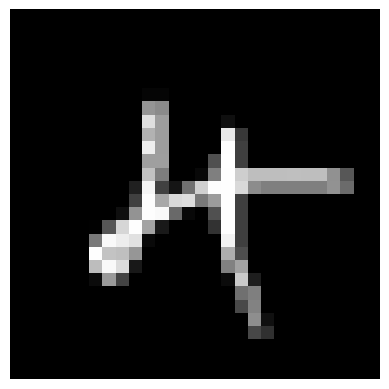

In [54]:
sample_model.test_prediction(25, X_test, y_test)

Prediction: [3]


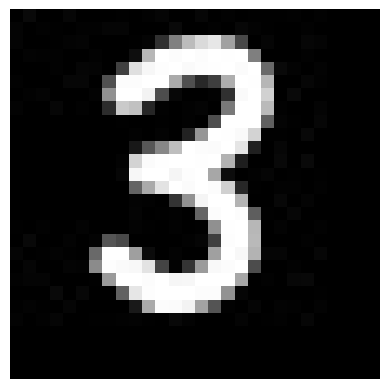

In [33]:
sample_model.test_sample_image('handwritten3.jpg')

Prediction: [1]


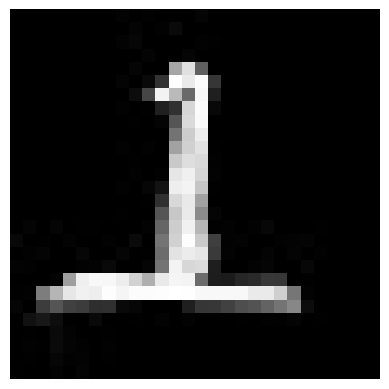

In [59]:
sample_model.test_sample_image('handwritten1.jpg')

In [60]:
import joblib as jb
jb.dump(sample_model, 'Handwritten_Digit_Recognizer.pkl')

['Handwritten_Digit_Recognizer.pkl']

In [61]:
loaded_model = jb.load('Handwritten_Digit_Recognizer.pkl')

Prediction: [1]


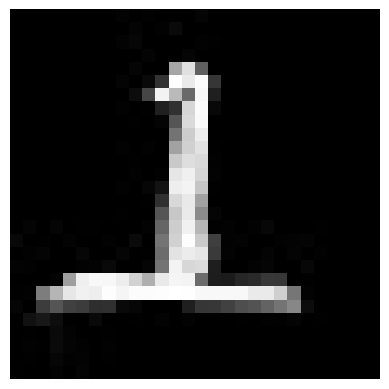

In [62]:
loaded_model.test_sample_image('handwritten1.jpg')